# 3. Modeling & Final Training

_In this notebook we:_  
1. Load the fully processed dataset from `data/processed/historical_proc.csv`.  
2. Verify that the target column (`target_up`) exists.  
3. Impute any remaining missing values.  
4. Define and tune our classifiers and regressors.  
5. Use TimeSeriesSplit for honest CV.  
6. Select the best classifier model.  
7. Retrain that classifier on 100% of the data.  
8. Save the final model for deployment.

### 1. Parameters & Papermill Setup
  1. Declare all variables you’ll define later so VS Code/Pylance stops complaining about `… is not defined`.  
  2. Set `DATA_PROCESSED` and `MODEL_DIR` for Papermill to override.  
  3. Default `USE_GPU=False` so on a CPU-only CI runner no GPU code paths are activated.

In [1]:
# Parameters cell for Papermill
DATA_PROCESSED = "data/processed"
MODEL_DIR      = "src/models"
USE_GPU        = False  # will be re-evaluated in Cell 2


In [2]:
# Parameters
DATA_PROCESSED = "data/processed"
MODEL_DIR = "src/models"


### 2. Imports, Styling & GPU Flag

- **multiprocessing.set_start_method('fork')** to avoid the `resource_tracker` warnings when using `n_jobs>1`.  
- Suppress deprecation/device warnings.  
- `%load_ext autotime` gives you per-cell timing.  
- Re-evaluate `USE_GPU` from the `CI_USE_GPU` environment variable.

In [3]:
# Cell 2 – Imports & GPU flag

import multiprocessing as mp
mp.set_start_method('fork', force=True)    # avoids resource_tracker errors

import os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import (
    RandomizedSearchCV, GridSearchCV,
    TimeSeriesSplit, ParameterGrid,
    cross_val_score
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier,
    RandomForestRegressor
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    classification_report,
    mean_squared_error,
    precision_recall_curve
)
import xgboost as xgb
from lightgbm import LGBMClassifier, LGBMRegressor
import joblib

# Notebook UI setup
warnings.filterwarnings("ignore", message=".*not used.*")
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)
%load_ext autotime

# Re-evaluate GPU flag at runtime (CI runner can set CI_USE_GPU=true)
USE_GPU = os.environ.get("CI_USE_GPU","false").lower() in ("1","true","yes")
print(f"→ USE_GPU = {USE_GPU}")

# Pre-declare names so linters/pylance won’t complain
best_lr = best_rf = best_xgb = best_lgb = None
stack_clf = None
feature_cols = []
imputer = None
X_train_imp = X_test_imp = None
keep_cols = []
best_regr = {}

→ USE_GPU = False
time: 531 μs (started: 2025-05-07 19:18:02 +00:00)


### 3. Load Features & Build Targets

- Read in the processed features CSV.  
- Sort by date, shift up to create “next-day” columns.  
- Define three targets:  
  - `target_up`: binary up/down tomorrow  
  - `target_high`, `target_low`: regression targets.  
- Drop the final row (it has no “next-day” values).

In [4]:
# Cell 3 – Load processed CSV and rebuild next‐day targets

print("DEBUG: data/processed contains:", os.listdir(DATA_PROCESSED))

df = pd.read_csv(
    os.path.join(DATA_PROCESSED, "historical_proc.csv"),
    parse_dates=["date"]
)
df.sort_values("date", inplace=True)

# Next-day shifts
df["close_next"] = df["close"].shift(-1)
df["high_next"]  = df["high"].shift(-1)
df["low_next"]   = df["low"].shift(-1)

# Classification & regression targets
df["target_up"]   = (df["close_next"] > df["close"]).astype(int)
df["target_high"] = df["high_next"]
df["target_low"]  = df["low_next"]

# Drop the last row (NaNs in any target)
df.dropna(subset=["target_up","target_high","target_low"], inplace=True)

DEBUG: data/processed contains: ['historical_proc.csv', 'coins_ohe.csv']


time: 17.2 s (started: 2025-05-07 19:18:02 +00:00)


### 4. Train / Test Split

- Select feature columns (`_std`, `_mm`, `PC*`, and date parts).  
- 75% of data for training, 25% for testing, preserving the time order.

In [5]:
# Cell 4 – Train/Test split (75% / 25%)

feature_cols = [
    c for c in df.columns
    if c.endswith(("_std","_mm"))   # scaled numeric features
    or c.startswith("PC")           # PCA components
    or c in ["year","month","day","weekday"]
]

X      = df[feature_cols]
y_up   = df["target_up"]
y_high = df["target_high"]
y_low  = df["target_low"]

split = int(len(df) * 0.75)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_up_train, y_up_test     = y_up.iloc[:split], y_up.iloc[split:]
y_high_train, y_high_test = y_high.iloc[:split], y_high.iloc[split:]
y_low_train, y_low_test   = y_low.iloc[:split], y_low.iloc[split:]

print(f"Train/Test size → {X_train.shape[0]} / {X_test.shape[0]}")

Train/Test size → 3299567 / 1099856
time: 68.2 ms (started: 2025-05-07 19:18:19 +00:00)


### 5. Impute Missing Values

- Use a `SimpleImputer(strategy="mean")`.  
- **Preserve** original DataFrame indices so later boolean masking stays aligned.

In [6]:
# Cell 5 – Impute missing values (mean)

imputer = SimpleImputer(strategy="mean")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=feature_cols,
    index=X_train.index
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=feature_cols,
    index=X_test.index
)

time: 731 ms (started: 2025-05-07 19:18:19 +00:00)


### Cell 6 – Initialize classifiers & parameter grids

In this cell we:

- Create a 3-fold time-series splitter.
- Instantiate:
  - **LogisticRegression** (always CPU).
  - **RandomForestClassifier** (always CPU).
  - **XGBClassifier** with `tree_method="gpu_hist"` + `gpu_id=0` if `USE_GPU`, otherwise `tree_method="hist"` only.
  - **LGBMClassifier** with GPU flags only under `USE_GPU`.
- Define small hyperparameter grids for each model.

In [7]:
# Cell 6 – Initialize classifiers & parameter grids

tscv = TimeSeriesSplit(n_splits=3)

# 1) Logistic Regression (CPU only)
lr_clf = LogisticRegression(
    class_weight="balanced", max_iter=2000, random_state=42
)

# 2) Random Forest (CPU only)
rf_clf = RandomForestClassifier(
    class_weight="balanced", n_jobs=1, random_state=42
)

# 3) XGBoost Classifier (GPU if flagged)
xgb_params = {
    "tree_method": "gpu_hist" if USE_GPU else "hist",
    "eval_metric": "logloss",
    "random_state": 42
}
if USE_GPU:
    xgb_params["gpu_id"] = 0
xgb_clf = xgb.XGBClassifier(**xgb_params)

# 4) LightGBM Classifier
lgb_params = {
    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.05,
    "random_state": 42
}
if USE_GPU:
    lgb_params.update(device="gpu", gpu_platform_id=0, gpu_device_id=0)
lgb_clf = LGBMClassifier(**lgb_params)

# Hyperparameter grids
param_lr  = {"C":[0.1,1]}
param_rf  = {"n_estimators":[50,100],"max_depth":[5,10]}
param_xgb = {"n_estimators":[100,200],"max_depth":[3,5],"learning_rate":[0.05,0.1]}
param_lgb = {"n_estimators":[100,200],"max_depth":[5,7],"learning_rate":[0.05,0.1]}

time: 1.34 ms (started: 2025-05-07 19:18:20 +00:00)


### 7. Fast Hyperparameter Tuning

- A helper `tune_fast` that:  
  1. Sub-samples RF on a fraction of the data  
  2. Chooses `GridSearchCV` vs. `RandomizedSearchCV`  
  3. Uses a thread pool (`parallel_backend('threading')`) to avoid resource-tracker issues

In [8]:
# Cell 7 – Fast tuning on 75% data (RandomizedSearchCV / GridSearchCV)

from datetime import datetime
from joblib import parallel_backend

def tune_fast(model, params, X, y, name, max_iter=3, frac=0.3):
    print(f"\n▶ Tuning {name} at {datetime.now():%H:%M:%S}")
    start = datetime.now()

    # Subsample only for RF to speed up
    if isinstance(model, RandomForestClassifier):
        n = int(len(X)*frac)
        idx = np.random.RandomState(42).choice(len(X), size=n, replace=False)
        Xt, yt = X.iloc[idx], y.iloc[idx]
    else:
        Xt, yt = X, y

    total = len(list(ParameterGrid(params)))
    if total <= max_iter:
        search = GridSearchCV(model, params, cv=tscv,
                              scoring="accuracy", n_jobs=1, verbose=2)
    else:
        search = RandomizedSearchCV(model, params, n_iter=max_iter,
                                    cv=tscv, scoring="accuracy",
                                    n_jobs=1, random_state=42, verbose=2)

    # Use threading backend to avoid multiprocessing tracker errors
    with parallel_backend("threading"):
        search.fit(Xt, yt)

    elapsed = (datetime.now()-start).total_seconds()
    print(f"✔ {name} done in {elapsed:.1f}s — "
          f"best={search.best_score_:.4f} @ {search.best_params_}")
    return search.best_estimator_

best_lr  = tune_fast(lr_clf,  param_lr,  X_train_imp, y_up_train, "Logistic")
best_rf  = tune_fast(rf_clf,  param_rf,  X_train_imp, y_up_train, "RandomForest")
best_xgb = tune_fast(xgb_clf, param_xgb, X_train_imp, y_up_train, "XGBoost")
best_lgb = tune_fast(lgb_clf, param_lgb, X_train_imp, y_up_train, "LightGBM")


▶ Tuning Logistic at 19:18:20
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[CV] END ..............................................C=0.1; total time=   4.3s


[CV] END ..............................................C=0.1; total time=   2.3s


[CV] END ..............................................C=0.1; total time=   2.8s


[CV] END ................................................C=1; total time=   4.0s


[CV] END ................................................C=1; total time=   2.2s


[CV] END ................................................C=1; total time=   2.7s


✔ Logistic done in 27.7s — best=0.4976 @ {'C': 0.1}

▶ Tuning RandomForest at 19:18:47


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[CV] END ......................max_depth=5, n_estimators=100; total time=  33.0s


[CV] END ......................max_depth=5, n_estimators=100; total time= 1.2min


[CV] END ......................max_depth=5, n_estimators=100; total time= 2.0min


[CV] END .....................max_depth=10, n_estimators=100; total time= 1.0min


[CV] END .....................max_depth=10, n_estimators=100; total time= 2.0min


[CV] END .....................max_depth=10, n_estimators=100; total time= 3.1min


[CV] END .......................max_depth=5, n_estimators=50; total time=  16.1s


[CV] END .......................max_depth=5, n_estimators=50; total time=  32.0s


[CV] END .......................max_depth=5, n_estimators=50; total time=  49.1s


✔ RandomForest done in 938.8s — best=0.7458 @ {'n_estimators': 100, 'max_depth': 10}

▶ Tuning XGBoost at 19:34:26
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   3.7s


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   6.7s


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  10.5s


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   3.6s


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   6.7s


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  10.1s


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.3s


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.2s


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   6.5s


✔ XGBoost done in 67.0s — best=0.6819 @ {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}

▶ Tuning LightGBM at 19:35:33
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[LightGBM] [Info] Number of positive: 382937, number of negative: 441957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464226 -> initscore=-0.143342
[LightGBM] [Info] Start training from score -0.143342


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   8.4s


[LightGBM] [Info] Number of positive: 835368, number of negative: 814417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506350 -> initscore=0.025400
[LightGBM] [Info] Start training from score 0.025400


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  14.2s


[LightGBM] [Info] Number of positive: 1228152, number of negative: 1246524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496288 -> initscore=-0.014848
[LightGBM] [Info] Start training from score -0.014848


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  20.0s


[LightGBM] [Info] Number of positive: 382937, number of negative: 441957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464226 -> initscore=-0.143342
[LightGBM] [Info] Start training from score -0.143342


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   8.0s


[LightGBM] [Info] Number of positive: 835368, number of negative: 814417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506350 -> initscore=0.025400
[LightGBM] [Info] Start training from score 0.025400


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  13.6s


[LightGBM] [Info] Number of positive: 1228152, number of negative: 1246524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496288 -> initscore=-0.014848
[LightGBM] [Info] Start training from score -0.014848


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  19.3s


[LightGBM] [Info] Number of positive: 382937, number of negative: 441957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464226 -> initscore=-0.143342
[LightGBM] [Info] Start training from score -0.143342


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   4.6s


[LightGBM] [Info] Number of positive: 835368, number of negative: 814417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506350 -> initscore=0.025400
[LightGBM] [Info] Start training from score 0.025400


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   8.0s


[LightGBM] [Info] Number of positive: 1228152, number of negative: 1246524


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496288 -> initscore=-0.014848
[LightGBM] [Info] Start training from score -0.014848


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  11.6s


[LightGBM] [Info] Number of positive: 1594956, number of negative: 1704611


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 3299567, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483383 -> initscore=-0.066491
[LightGBM] [Info] Start training from score -0.066491


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


✔ LightGBM done in 130.1s — best=0.6907 @ {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
time: 19min 23s (started: 2025-05-07 19:18:20 +00:00)


### 8. Build & Train Prefitted Stacking

- Stack the four tuned CPU/GPU-safe base models.  
- Use a `LogisticRegression` meta-learner.  
- `cv="prefit"` since base models are already trained.

In [9]:
# Cell 8 – Prefit stacking ensemble

from datetime import datetime

print(f"[{datetime.now():%H:%M:%S}] Building stacking ensemble")
stack_clf = StackingClassifier(
    estimators=[("lr",best_lr),("rf",best_rf),
                ("xgb",best_xgb),("lgb",best_lgb)],
    final_estimator=LogisticRegression(max_iter=2000),
    cv="prefit",
    n_jobs=1
)
stack_clf.fit(X_train_imp, y_up_train)
print("✅ Stacking complete")

[19:37:43] Building stacking ensemble


✅ Stacking complete
time: 29.5 s (started: 2025-05-07 19:37:43 +00:00)


### 9. Evaluate on Test Set

- For each model, compute accuracy, print a classification report, and show a confusion matrix heatmap.


► Logistic Accuracy: 0.4980


              precision    recall  f1-score   support

           0       0.50      0.19      0.27    554087
           1       0.50      0.82      0.62    545769

    accuracy                           0.50   1099856
   macro avg       0.50      0.50      0.44   1099856
weighted avg       0.50      0.50      0.44   1099856



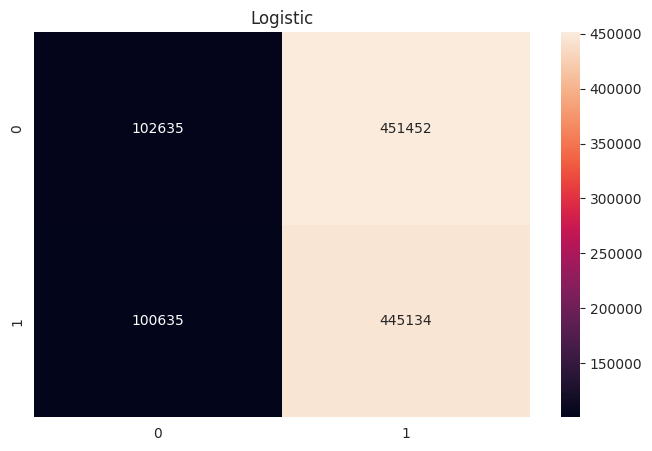


► RandomForest Accuracy: 0.7264
              precision    recall  f1-score   support

           0       0.70      0.81      0.75    554087
           1       0.77      0.64      0.70    545769

    accuracy                           0.73   1099856
   macro avg       0.73      0.73      0.72   1099856
weighted avg       0.73      0.73      0.72   1099856



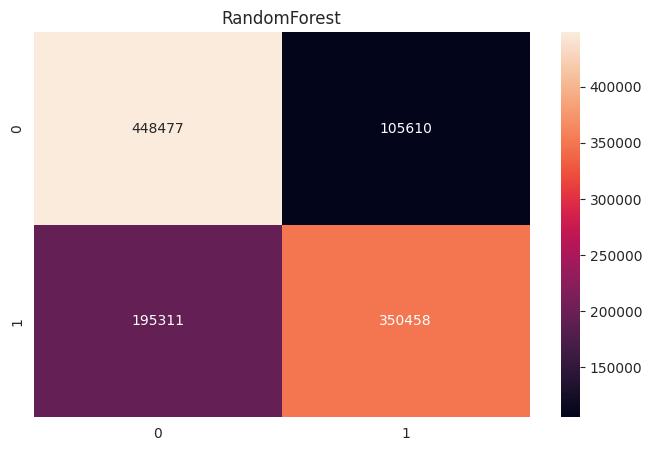


► XGBoost Accuracy: 0.7209
              precision    recall  f1-score   support

           0       0.68      0.84      0.75    554087
           1       0.78      0.60      0.68    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.72      0.72   1099856
weighted avg       0.73      0.72      0.72   1099856



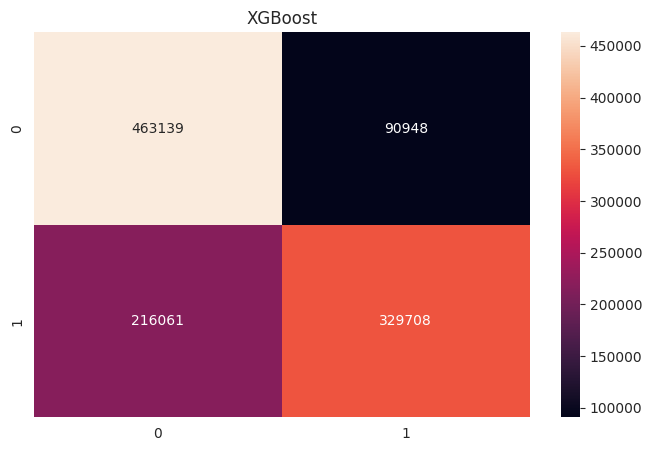


► LightGBM Accuracy: 0.7175
              precision    recall  f1-score   support

           0       0.68      0.85      0.75    554087
           1       0.79      0.59      0.67    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.72      0.71   1099856
weighted avg       0.73      0.72      0.71   1099856



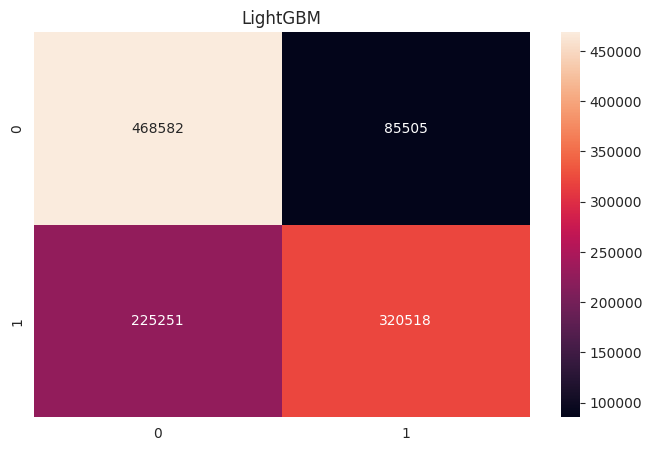


► Stacking Accuracy: 0.7169
              precision    recall  f1-score   support

           0       0.68      0.84      0.75    554087
           1       0.79      0.59      0.67    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.72      0.71   1099856
weighted avg       0.73      0.72      0.71   1099856



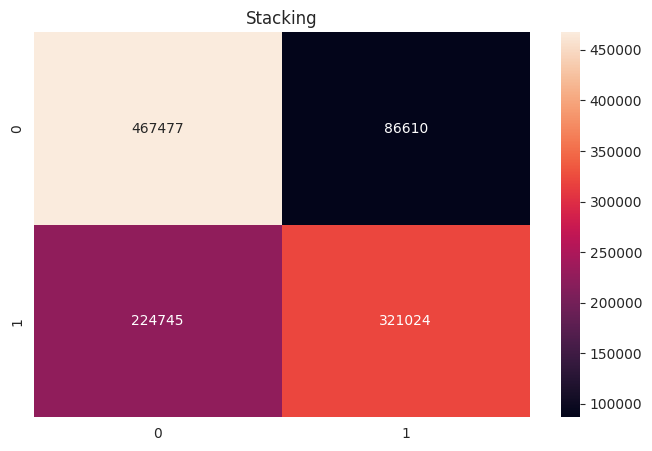

time: 19.1 s (started: 2025-05-07 19:38:13 +00:00)


In [10]:
# Cell 9 – Classification metrics on the 25% hold-out

for name, mdl in [
    ("Logistic", best_lr),
    ("RandomForest", best_rf),
    ("XGBoost", best_xgb),
    ("LightGBM", best_lgb),
    ("Stacking", stack_clf)
]:
    y_pred = mdl.predict(X_test_imp)
    acc    = accuracy_score(y_up_test, y_pred)
    print(f"\n► {name} Accuracy: {acc:.4f}")
    print(classification_report(y_up_test, y_pred))
    sns.heatmap(confusion_matrix(y_up_test, y_pred), annot=True, fmt="d")
    plt.title(name)
    plt.show()

### 10. ROC Curves & AUC for All Classifiers

Next, we’ll compute the ROC curve and the Area Under Curve (AUC)  
for each of our classifiers on the test set, so we can compare their  
true-positive vs. false-positive trade-offs.

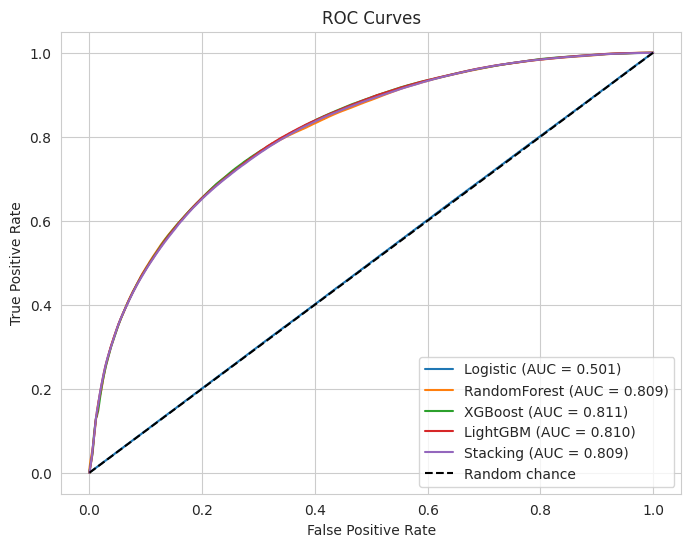

time: 18.9 s (started: 2025-05-07 19:38:32 +00:00)


In [11]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, mdl in [
    ("Logistic", best_lr),
    ("RandomForest", best_rf),
    ("XGBoost", best_xgb),
    ("LightGBM", best_lgb),
    ("Stacking", stack_clf)
]:
    probas = mdl.predict_proba(X_test_imp)[:,1]
    fpr, tpr, _ = roc_curve(y_up_test, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random chance")  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

### 11. Precision–Recall Threshold Optimization

- Compute the precision–recall curve on the stacking model’s probabilities.  
- Pick the threshold that maximizes F₁, then re-evaluate at that threshold.

In [12]:
# Cell 11 – PR‐curve threshold tuning for stacker

probs = stack_clf.predict_proba(X_test_imp)[:,1]
prec, rec, thr = precision_recall_curve(y_up_test, probs)
f1 = 2*prec*rec/(prec+rec)
opt_thresh = thr[np.nanargmax(f1)]
print(f"Optimal threshold: {opt_thresh:.3f}")

y_opt = (probs >= opt_thresh).astype(int)
print("Stack@opt Acc:", accuracy_score(y_up_test, y_opt))
print(classification_report(y_up_test, y_opt))

Optimal threshold: 0.220
Stack@opt Acc: 0.7146544638570868
              precision    recall  f1-score   support

           0       0.79      0.59      0.67    554087
           1       0.67      0.84      0.75    545769

    accuracy                           0.71   1099856
   macro avg       0.73      0.72      0.71   1099856
weighted avg       0.73      0.71      0.71   1099856

time: 9.2 s (started: 2025-05-07 19:38:51 +00:00)


### 12. Define & (Optionally) Tune Regressors

- We’ll predict tomorrow’s high/low with RF/LGBM/XGB regressors.  
- Same `USE_GPU` guard ensures no OpenCL errors in CI.

In [13]:
# Cell 12 – Optional: Tune & Train Regressors for High/Low Price Prediction (fast, noise‐free)

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble          import RandomForestRegressor
from lightgbm                  import LGBMRegressor
import xgboost                 as xgb

# 1) Subset training data, dropping NaNs in each target
mask_h = ~y_high_train.isna()
mask_l = ~y_low_train.isna()
Xh, yh = X_train_imp.loc[mask_h], y_high_train.loc[mask_h]
Xl, yl = X_train_imp.loc[mask_l], y_low_train.loc[mask_l]

# 2) Remove zero‐variance features
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_train_imp)
keep_cols = [c for c, keep in zip(feature_cols, vt.get_support()) if keep]
Xh = Xh[keep_cols]
Xl = Xl[keep_cols]

# 3) Define regressors (CPU‐only, verbose silenced)
rf_regr = RandomForestRegressor(n_estimators=100, max_depth=7,
                                n_jobs=1, random_state=42)

lgb_regr = LGBMRegressor(n_estimators=100,
                         max_depth=7,
                         min_child_samples=20,
                         learning_rate=0.05,
                         random_state=42,
                         n_jobs=1,
                         verbose=-1)   # silence “no further splits” warnings

xgb_regr = xgb.XGBRegressor(tree_method="hist",
                           objective="reg:squarederror",
                           eval_metric="rmse",
                           n_estimators=100,
                           max_depth=7,
                           learning_rate=0.05,
                           random_state=42,
                           n_jobs=1)

# 4) Train each “grid” (here only one set each) directly, no CV
best_regr = {}
for name, (mdl, Xtr, ytr) in [
    ("RF High",  (rf_regr,  Xh, yh)),
    ("LGB High", (lgb_regr, Xh, yh)),
    ("XGB High", (xgb_regr, Xh, yh)),
    ("RF Low",   (rf_regr,  Xl, yl)),
    ("LGB Low",  (lgb_regr, Xl, yl)),
    ("XGB Low",  (xgb_regr, Xl, yl)),
]:
    print(f"\n▶ Training {name}")
    mdl.fit(Xtr, ytr)
    best_regr[name] = mdl
    print(f"✔ {name} done.")


▶ Training RF High


✔ RF High done.

▶ Training LGB High


✔ LGB High done.

▶ Training XGB High


✔ XGB High done.

▶ Training RF Low


✔ RF Low done.

▶ Training LGB Low


✔ LGB Low done.

▶ Training XGB Low


✔ XGB Low done.
time: 1h 18min 11s (started: 2025-05-07 19:39:00 +00:00)


### 13. Visualize Regressor Performance

- Plot predicted vs. actual tomorrow’s high/low for each tuned regressor.  
- Compute RMSE and overlay a 1:1 line.

LGB High — RMSE: 38674441.38


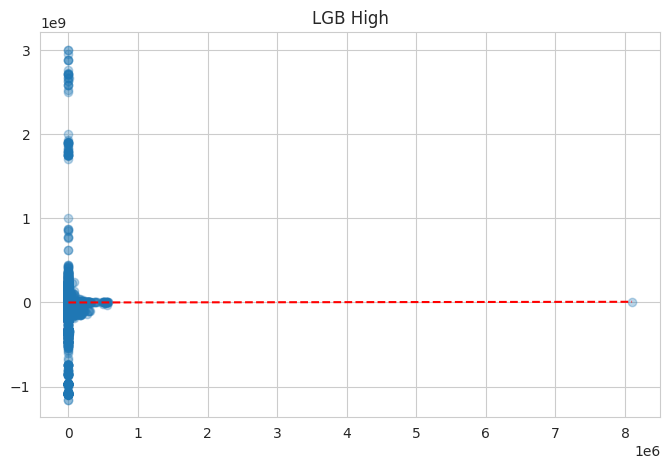

XGB High — RMSE: 177272871.75


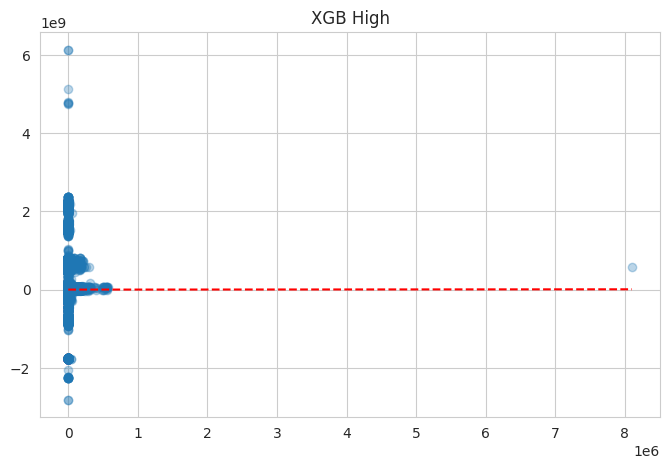

RF High — RMSE: 241411216.37


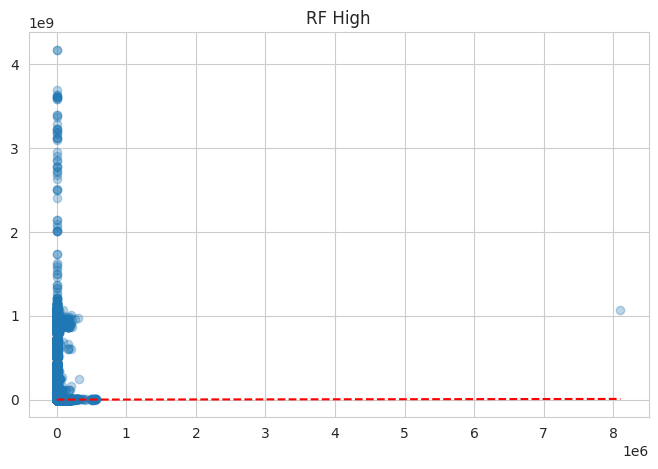

LGB Low — RMSE: 38674427.41


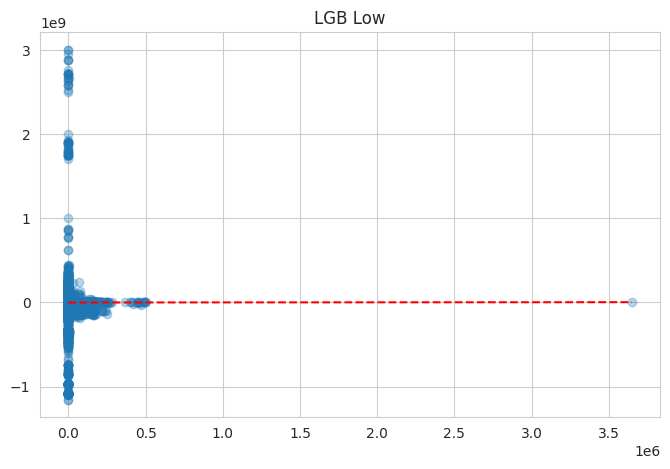

XGB Low — RMSE: 177272900.73


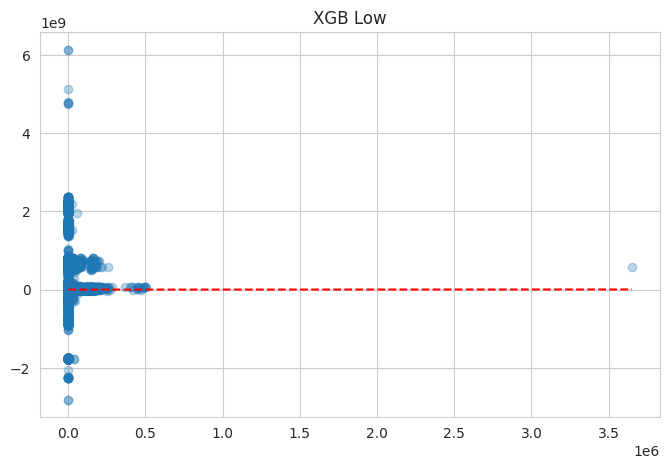

RF Low — RMSE: 241411243.88


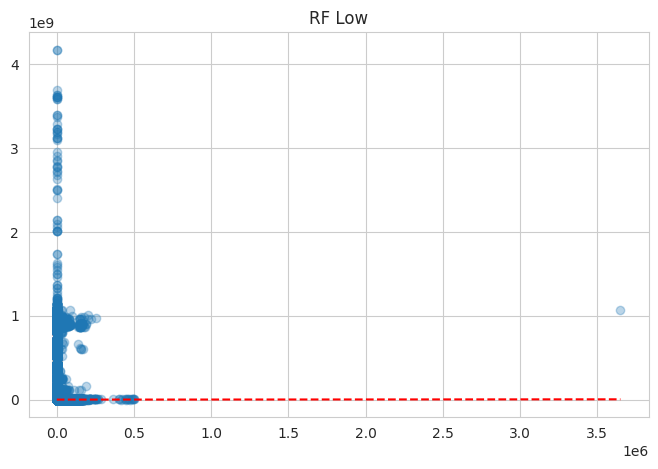

time: 22.4 s (started: 2025-05-07 20:57:12 +00:00)


In [14]:
# Cell 13 – RMSE scatter plots

def eval_reg(name, model, X_te, y_te):
    yp   = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, yp))
    print(f"{name} — RMSE: {rmse:.2f}")
    plt.scatter(y_te, yp, alpha=0.3)
    plt.plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],'r--')
    plt.title(name)
    plt.show()

for nm in ["LGB High","XGB High","RF High","LGB Low","XGB Low","RF Low"]:
    eval_reg(nm, best_regr[nm], X_test_imp[keep_cols], 
             {"LGB High":y_high_test,
              "XGB High":y_high_test,
              "RF High": y_high_test,
              "LGB Low": y_low_test,
              "XGB Low": y_low_test,
              "RF Low":  y_low_test}[nm])


### 14. Full-Data CV, Select & Retrain, Save

1. Re-load the full dataset.  
2. Time-series CV on **all** data to pick the overall best model.  
3. Retrain that model on 100% of the data.  
4. Save to `src/models/final_{model}.pkl`.

In [15]:
# Cell 14 – Full‐Data CV (base models only), Select & Retrain Best Model, Then Save

# 1) Load full processed data
df_full = pd.read_csv(
    os.path.join(DATA_PROCESSED, "historical_proc.csv"),
    parse_dates=["date"]
)
df_full.sort_values("date", inplace=True)

# 1b) Re‐create next‐day targets on the full data
df_full["close_next"] = df_full["close"].shift(-1)
df_full["high_next"]  = df_full["high"].shift(-1)
df_full["low_next"]   = df_full["low"].shift(-1)
df_full["target_up"]   = (df_full["close_next"] > df_full["close"]).astype(int)
df_full["target_high"] = df_full["high_next"]
df_full["target_low"]  = df_full["low_next"]
df_full.dropna(subset=["target_up","target_high","target_low"], inplace=True)

# 2) Prepare features & labels
Xf = pd.DataFrame(
    imputer.transform(df_full[feature_cols]),
    columns=feature_cols
)
yf = df_full["target_up"]

# 3) Full‐data time‐series CV (base models only)
tscv_full = TimeSeriesSplit(n_splits=3)
candidates = {
    "Logistic":     best_lr,
    "RandomForest": best_rf,
    "XGBoost":      best_xgb,
    "LightGBM":     best_lgb
    # Note: stacking ensemble omitted here because it was built with cv="prefit"
}

scores = {}
for name, model in candidates.items():
    sc = cross_val_score(
        model, Xf, yf,
        cv=tscv_full,
        scoring="accuracy",
        n_jobs=1
    )
    scores[name] = sc.mean()
    print(f"{name} full‐CV: {sc.mean():.4f} ± {sc.std():.4f}")

# 4) Select best and retrain on all data
best_name   = max(scores, key=scores.get)
final_model = candidates[best_name]
print(f"\n▶ Best on full‐CV: {best_name}")
final_model.fit(Xf, yf)

# 5) Save the final model artifact
os.makedirs(MODEL_DIR, exist_ok=True)
out_path = os.path.join(MODEL_DIR, f"final_{best_name.lower()}.pkl")
joblib.dump(final_model, out_path)
print(f"Saved {os.path.basename(out_path)} to {MODEL_DIR}/")

Logistic full‐CV: 0.5039 ± 0.0068


RandomForest full‐CV: 0.6976 ± 0.0219


XGBoost full‐CV: 0.6917 ± 0.0222


LightGBM full‐CV: 0.6910 ± 0.0193

▶ Best on full‐CV: RandomForest


Saved final_randomforest.pkl to src/models/
time: 51min 37s (started: 2025-05-07 20:57:35 +00:00)


## 15. Manual Prediction Testing

Once we’ve selected and saved our **final model** (e.g. `final_lightgbm.pkl`), it’s handy to be able to feed it *one* manually-specified input and see what it predicts:

1. **Load** the trained model and the `SimpleImputer` instance.  
2. **Build** a single-row `pd.DataFrame` whose columns exactly match `feature_cols`.  
3. **Impute** any missing values (just in case).  
4. **Call** `model.predict()` (and `model.predict_proba()` if you want probabilities).  

Below is a worked example that:
- Grabs the very first row of your _test_ set as a template  
- Shows how to swap in your own values  
- Prints out the predicted class (“up” vs. “down”) and the probability

In [16]:
# Cell 15 — Manual test harness for final_model

import os
import glob
import joblib
import pandas as pd

# 1) Locate and load the “final” model artifact
model_paths = glob.glob(os.path.join(MODEL_DIR, "final_*.pkl"))
if not model_paths:
    raise FileNotFoundError(f"No final_*.pkl found in {MODEL_DIR!r}")
model_path = model_paths[0]
model = joblib.load(model_path)
print(f"Loaded model from: {model_path}")

# 2) Grab a template row from the already-imputed test set
#    (X_test_imp was created in Cell 5)
sample_df = X_test_imp.iloc[[0]].copy()
print("Template sample (first test row):")
display(sample_df)

# 3) [Optional] Modify any feature(s) to experiment:
#    e.g. sample_df["price_std"] = 0.5

# 4) Re-order and select exactly the same columns we trained on
sample_df = sample_df[feature_cols]

# 5) Re-impute (in case you manually set values to NaN)
#    (imputer was defined in Cell 5)
X_input = pd.DataFrame(
    imputer.transform(sample_df),
    columns=feature_cols,
    index=sample_df.index
)

# 6) Run prediction & probability
pred_class = model.predict(X_input)[0]
pred_proba = model.predict_proba(X_input)[0]

print(f"\nPredicted class (0 = down, 1 = up): {pred_class}")
print(f"Predicted probabilities [P(down), P(up)]: {pred_proba}")


Loaded model from: src/models/final_randomforest.pkl
Template sample (first test row):


,year,month,day,weekday,price_std,market_cap_std,volume_24h_std,percent_change_24h_std,price_mm,market_cap_mm,volume_24h_mm,percent_change_24h_mm,PC1,PC2,PC3,PC4
3337958,2020.0,12.0,8.0,1.0,-0.004116,-0.001334,-0.000703,-0.000696,1.215616e-09,5.643277e-08,1.948127e-10,4.955890e-09,-0.003883,-0.001535,-0.000697,-0.001334



Predicted class (0 = down, 1 = up): 0
Predicted probabilities [P(down), P(up)]: [0.87816698 0.12183302]
time: 56.6 ms (started: 2025-05-07 21:49:12 +00:00)
